In [1]:
# Four‑layer ConvNet to facial emotion recognition with minimal epochs and the signifcance of data diversity
# data_dir = "C:/Users/Administrator/Desktop/data/jaffedbase/Jaffe"
import os
import cv2
import numpy as np
import tensorflow as tf
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate, Dropout  # Add Dropout here
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# Set the path to your dataset folder.
data_dir = "C:/Users/Administrator/Desktop/data/Cancer_Inbreast/InBreast"

# Define a function to load and preprocess the images from the dataset folder.
def load_and_preprocess_images(data_dir):
    X_images = []
    y_labels = []
    
    for emotion_folder in os.listdir(data_dir):
        emotion_label = emotion_folder  # Assuming folder names are the labels.
        emotion_folder_path = os.path.join(data_dir, emotion_folder)
        
        for image_file in os.listdir(emotion_folder_path):
            image_path = os.path.join(emotion_folder_path, image_file)
            image = cv2.imread(image_path)
            # Resize the image to your desired dimensions (e.g., 128x128).
            image = cv2.resize(image, (128, 128))
            # Convert the image to grayscale.
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X_images.append(gray_image)
            y_labels.append(emotion_label)
    
    return np.array(X_images), np.array(y_labels)

# Load and preprocess your facial images dataset.
X_images, y_labels = load_and_preprocess_images(data_dir)

# Define a function to extract LBP features from an image.
def extract_lbp_features(image):
    radius = 3
    n_points = 24
    lbp_image = feature.local_binary_pattern(image, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Extract LBP features from all images in your dataset.
X_lbp_features = [extract_lbp_features(image) for image in X_images]

# Convert the extracted LBP features to a NumPy array.
X_lbp_features = np.array(X_lbp_features)

# Define a function to create a CNN model for feature extraction from facial images.
def create_cnn_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3),  activation='relu'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))   
    model.add(Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3),  activation='relu'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
    model.add(Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(256, (3, 3),  activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
    model.add(Dropout(0.25))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    return model
#model.summary()
# Define the input shape for your CNN model based on your image dimensions.
cnn_input_shape = (128, 128, 1)  # Assuming grayscale images with one channel.

# Create the CNN model.
cnn_model = create_cnn_model(cnn_input_shape)

# Define the combined model to concatenate CNN and LBP features.
cnn_output = cnn_model.output
lbp_input = Input(shape=(X_lbp_features.shape[1],))
concatenated = concatenate([cnn_output, lbp_input])
output = Dense(len(np.unique(y_labels)), activation='sigmoid')(concatenated)

model = Model(inputs=[cnn_model.input, lbp_input], outputs=output)

# Compile the combined model.
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Split your dataset into training and testing sets.
X_cnn_train, X_cnn_test, X_lbp_train, X_lbp_test, y_train, y_test = train_test_split(
    X_images, X_lbp_features, y_labels, test_size=0.2, random_state=42)

# Encode the labels using LabelEncoder and one-hot encoding.
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

# Standardize the LBP features.
scaler = StandardScaler()
X_lbp_train = scaler.fit_transform(X_lbp_train)
X_lbp_test = scaler.transform(X_lbp_test)



Epoch 1/100
153/153 [==============================] - 182s 1s/step - loss: 0.7742 - accuracy: 0.5832 - val_loss: 0.6162 - val_accuracy: 0.6945
Epoch 2/100
153/153 [==============================] - 174s 1s/step - loss: 0.6532 - accuracy: 0.6734 - val_loss: 0.5955 - val_accuracy: 0.7117
Epoch 3/100
153/153 [==============================] - 182s 1s/step - loss: 0.6211 - accuracy: 0.6801 - val_loss: 0.5981 - val_accuracy: 0.6953
Epoch 4/100
153/153 [==============================] - 174s 1s/step - loss: 0.5955 - accuracy: 0.7028 - val_loss: 0.5759 - val_accuracy: 0.7305
Epoch 5/100
153/153 [==============================] - 179s 1s/step - loss: 0.5838 - accuracy: 0.7059 - val_loss: 0.5716 - val_accuracy: 0.7453
Epoch 6/100
153/153 [==============================] - 186s 1s/step - loss: 0.5687 - accuracy: 0.7209 - val_loss: 0.5505 - val_accuracy: 0.7559
Epoch 7/100
153/153 [==============================] - 178s 1s/step - loss: 0.5593 - accuracy: 0.7213 - val_loss: 0.5719 - val_accuracy:

153/153 [==============================] - 168s 1s/step - loss: 0.0445 - accuracy: 0.9838 - val_loss: 0.2404 - val_accuracy: 0.9394
Epoch 58/100
153/153 [==============================] - 168s 1s/step - loss: 0.0415 - accuracy: 0.9838 - val_loss: 0.1628 - val_accuracy: 0.9484
Epoch 59/100
153/153 [==============================] - 168s 1s/step - loss: 0.0419 - accuracy: 0.9851 - val_loss: 0.1559 - val_accuracy: 0.9533
Epoch 60/100
153/153 [==============================] - 168s 1s/step - loss: 0.0309 - accuracy: 0.9896 - val_loss: 0.1620 - val_accuracy: 0.9590
Epoch 61/100
153/153 [==============================] - 168s 1s/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 0.3341 - val_accuracy: 0.9165
Epoch 62/100
153/153 [==============================] - 168s 1s/step - loss: 0.0342 - accuracy: 0.9863 - val_loss: 0.2643 - val_accuracy: 0.9189
Epoch 63/100
153/153 [==============================] - 168s 1s/step - loss: 0.0360 - accuracy: 0.9873 - val_loss: 0.2374 - val_accuracy: 0.937

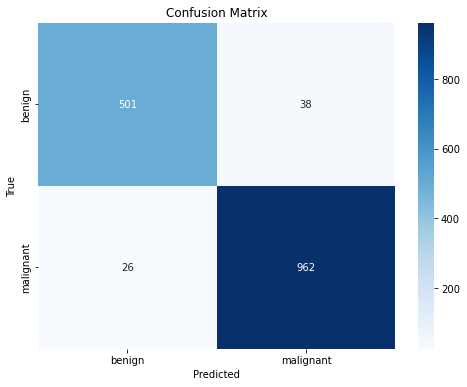

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model.
history = model.fit([X_cnn_train, X_lbp_train], y_train_onehot, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set.
loss, accuracy = model.evaluate([X_cnn_test, X_lbp_test], y_test_onehot)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Generate a classification report.
y_pred = model.predict([X_cnn_test, X_lbp_test])
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
print(classification_report(y_test, y_pred_labels))

# Generate a confusion matrix.
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

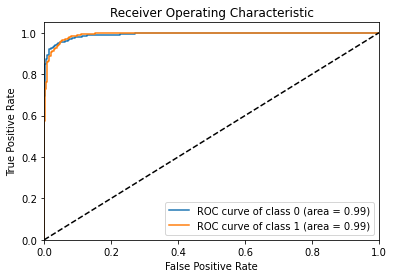

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y_labels))
y_score = model.predict([X_cnn_test, X_lbp_test])
y_test_categorical = to_categorical(label_encoder.transform(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


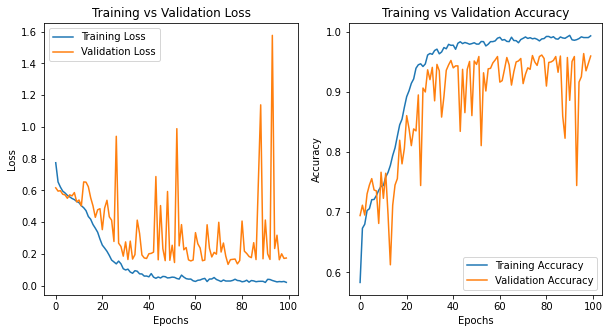

In [4]:
# Access the training history to plot the training and validation loss and accuracy.
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training versus validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training versus validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
# Calculate the kappa statistic.
kappa_statistic = cohen_kappa_score(y_test, y_pred_labels)
print(f"Kappa Statistic: {kappa_statistic:.4f}")

# Calculate the False Negative Rate.
TN, FP, FN, TP = cm.ravel()
FNR = FN / (FN + TP)
print(f"False Negative Rate: {FNR:.4f}")

Kappa Statistic: 0.9078
False Negative Rate: 0.0263


In [6]:
from sklearn.metrics import recall_score


# Calculate the sensitivity (true positive rate).
sensitivity = recall_score(y_test, y_pred_labels, average='macro')
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")


Sensitivity (True Positive Rate): 0.9516
